In [2]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Activation, Dropout
from sklearn.metrics import mean_squared_error
import math

plt.style.use('ggplot')

print(tf.__version__)
print(np.__version__)
print(yf.__version__)

2.1.0
1.18.1
0.1.54


Using TensorFlow backend.


In [3]:
def plot_history(result):
    history = result.history
    fig = plt.figure(figsize=(6, 6))
    ax1 = plt.subplot(211)
    ax1.plot(history['loss'], label='loss')
    ax1.plot(history['val_loss'], label='val_loss')
    ax1.legend()
    ax1.grid()
    
    ax2 = plt.subplot(212, sharex=ax1)
    ax2.plot(history['accuracy'], label='accuracy')
    ax2.plot(history['val_accuracy'], label='val_accuracy')
    ax2.legend()
    ax2.grid()

In [10]:
btc_close = yf.download('BTC-USD', start='2018-05-04', interval='1d')['Close']
btc_close.tail()

[*********************100%***********************]  1 of 1 completed


Date
2020-09-18    10944.585938
2020-09-19    11094.346680
2020-09-20    10938.271484
2020-09-21    10462.259766
2020-09-22    10483.603516
Name: Close, dtype: float64

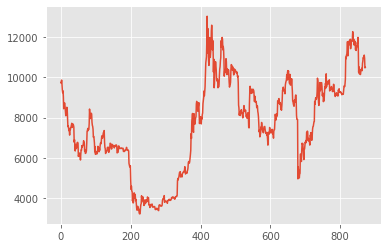

In [11]:
#reshaping to n_data, 1:
index = btc_close.index
btc = btc_close.values.reshape(len(btc_close), 1)
#btc is now numpy array!
plt.plot(btc)
plt.show()

In [12]:
#normalize data
scaler = MinMaxScaler(feature_range=(0,1))

In [13]:
btc_normalized = scaler.fit_transform(btc)

In [14]:
#split data into train and test
train_size = int(len(btc_normalized)* 0.8)
test_size = len(btc_normalized) - train_size
btc_train, btc_test = btc_normalized[0:train_size], btc_normalized[train_size:len(btc_normalized)]

In [15]:
print(btc_train.shape, btc_test.shape)

(698, 1) (175, 1)


In [16]:
def create_sets(dataset, n_in, n_out):
    max_range = dataset.shape[0] - n_in - 1
    X = np.empty([max_range, n_in])
    Y = np.empty([max_range, n_out])
    for i in range(max_range):
        X[i] = dataset[i : (i + n_in), 0]
        Y[i] = dataset[(i + n_in) : (i + n_in + n_out), 0]
    return np.array(X), np.array(Y)

In [17]:
n_in = 14
n_out = 1
n_features = 1 #currently only price
trainX, trainY = create_sets(btc_train, n_in, n_out)
trainX = np.expand_dims(trainX, -1)

In [21]:
create_sets?

In [22]:
#build the model
model = Sequential()
model.add(LSTM(50, input_shape=(n_in, n_features), activation='relu'))
model.add(Dense(n_out))
model.compile(loss='mse', optimizer='adam')
model.summary()
#fit the model
res = model.fit(trainX, trainY, epochs=20, batch_size=32)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50)                10400     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
683/683 [==============================] - 0s 697us/step - loss: 0.0693
Epoch 2/20
683/683 [==============================] - 0s 216us/step - loss: 0.0073
Epoch 3/20
683/683 [==============================] - 0s 267us/step - loss: 0.0043
Epoch 4/20
683/683 [==============================] - 0s 253us/step - loss: 0.0033
Epoch 5/20
683/683 [==============================] - 0s 254us/step - loss: 0.0030
Epoch 6/20
683/683 [==============================] - 0s 223us/step - loss: 0.0028
Epoch 7/20
683

In [23]:
testX, testY = create_sets(btc_test, n_in, n_out)
testX = np.expand_dims(testX, -1)

In [24]:
test_predictions = scaler.inverse_transform(model.predict(testX))
train_predictions = scaler.inverse_transform(model.predict(trainX))

In [25]:
test_predictions.shape

(160, 1)

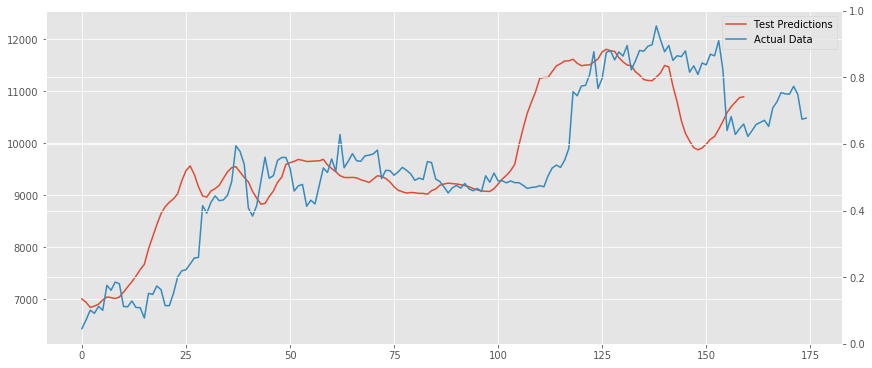

In [26]:
fig, ax = plt.subplots(constrained_layout=True, figsize=(12, 5))
ax.plot(test_predictions, label='Test Predictions')
ax.plot(scaler.inverse_transform(btc_test), label='Actual Data')
ax.legend()
ax2 = ax.twinx()

#ax2.plot(test_predictions - scaler.inverse_transform(btc_test))

In [48]:
def create_ts(ds, series):
    X, Y =[], []
    max_range = len(ds) - series - 1
    for i in range(max_range):
        item = ds[i:(i+series), 0]
        X.append(item)
        Y.append(ds[i+series, 0])
    return np.array(X), np.array(Y)

series = 7

trainX, trainY = create_ts(btc_train, series)
testX, testY = create_ts(btc_test, series)
print(trainX.shape, trainY.shape)
#reshape into  LSTM format - samples, steps, features
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))



print(trainX.shape, trainY.shape)

(690, 7) (690,)


IndexError: tuple index out of range

In [47]:
len(trainY)

1

In [45]:
#build the model
model = Sequential()
model.add(LSTM(4, input_shape=(series, 1)))
model.add(Dense(690))
model.compile(loss='mse', optimizer='adam')
#fit the model
model.fit(trainX, trainY, epochs=100, batch_size=32)

ValueError: Input arrays should have the same number of samples as target arrays. Found 690 input samples and 1 target samples.

In [30]:
#test this model out
trainPredictions = model.predict(trainX)
testPredictions = model.predict(testX)
#unscale predictions
trainPredictions = scaler.inverse_transform(trainPredictions)
testPredictions = scaler.inverse_transform(testPredictions)
trainY = scaler.inverse_transform([trainY])
testY = scaler.inverse_transform([testY])

ValueError: Found array with dim 3. Estimator expected <= 2.

In [31]:
#lets calculate the root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredictions[:, 0]))
testScore = math.sqrt(mean_squared_error(testY[0], testPredictions[:, 0]))
print('Train score: %.2f rmse', trainScore)
print('Test score: %.2f rmse', testScore)

Train score: %.2f rmse 461.8755501328388
Test score: %.2f rmse 388.2548336306494


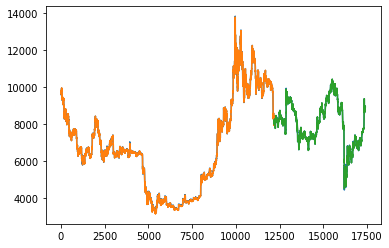

In [208]:
#lets plot the predictions on a graph and see how well it did
train_plot = np.empty_like(btc)
train_plot[:,:] = np.nan
train_plot[series:len(trainPredictions)+series, :] = trainPredictions

test_plot = np.empty_like(btc)
test_plot[:,:] = np.nan
test_plot[len(trainPredictions)+(series*2)+1:len(btc)-1, :] = testPredictions

#plot on graph
plt.plot(scaler.inverse_transform(btc_normalized))
plt.plot(train_plot)
plt.plot(test_plot)
plt.show()

In [198]:
np.where(np.isin(scaler.inverse_transform(btc), scaler.inverse_transform(testX[-1])))

(array([], dtype=int64), array([], dtype=int64))

In [210]:
scaler.inverse_transform(model.predict(np.array([btc_normalized[-8:-1]])))

array([[8907.822]], dtype=float32)